In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random

In [2]:
from sklearn.preprocessing import StandardScaler


In [313]:
segment_directory = "data/segmentation.csv"

segment = pd.read_csv(segment_directory, header=0,parse_dates=['Recency'])


In [314]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


Для начала избавимся от CustomerId и Recency, ко второму, скорее всего, мы еще вернемся

In [315]:
segment_dropped = segment.drop(columns=['CustomerId','Recency'],axis=1)

У нас есть общие затраты и их количество, можем рассмотреть среднее для каждого покупателя

In [316]:
segment_dropped['mean'] = segment_dropped['Monetary']/segment_dropped['Frequency']

In [317]:
segment_dropped.head()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,mean
0,100.40,6,0.35,0.08,0.609740,0.949383,16.733333
1,170.00,4,0.66,0.16,0.942272,0.479846,42.500000
2,70.75,6,0.92,0.20,0.323030,0.007076,11.791667
3,75.00,10,0.35,0.78,0.876833,0.088974,7.500000
4,94.51,5,0.51,0.44,0.912099,0.206194,18.902000


Построим график зависимости среднего значения от частоты. По нему можно сказать, что чем больше транзакций происходит у пользователя, тем меньше средняя стоимость этой транзакции 

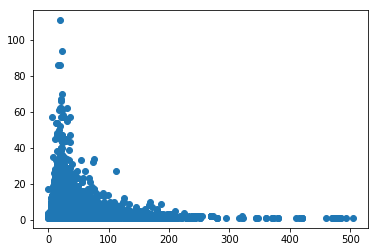

In [318]:
plt.scatter(x=segment_dropped['mean'],y=segment_dropped['Frequency']);

Попробуем оценить клиентов по количеству платежей, посмотрим статистику для тех, у кого был совершен только один платеж 

In [319]:
one_time=(segment_dropped[segment_dropped['Frequency'] == 1])
one_time.describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,mean
count,5530.000000,5530.0,5530.000000,5530.000000,5530.000000,5530.000000,5530.000000
mean,39.595009,1.0,0.499792,0.494919,0.495766,0.499357,39.595009
std,77.455206,0.0,0.291386,0.291027,0.289140,0.285901,77.455206
min,0.000000,1.0,0.000000,0.000000,0.000176,0.000107,0.000000
25%,8.322500,1.0,0.250000,0.240000,0.242593,0.254295,8.322500
50%,19.860000,1.0,0.500000,0.500000,0.499507,0.496084,19.860000
75%,42.230000,1.0,0.750000,0.750000,0.739781,0.746769,42.230000
max,504.000000,1.0,1.000000,1.000000,0.999992,0.999943,504.000000


Для тех, у кого было больше одного платежа

In [320]:
several_time=(segment_dropped[segment_dropped['Frequency'] > 1])
several_time.describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,mean
count,10470.000000,10470.000000,10470.000000,10470.000000,10470.000000,10470.000000,10470.000000
mean,177.707337,5.509169,0.500122,0.499419,0.495284,0.497936,34.973321
std,199.117546,5.842446,0.289500,0.291145,0.288992,0.289843,34.107268
min,0.000000,2.000000,0.000000,0.000000,0.000037,0.000033,0.000000
25%,46.770000,2.000000,0.250000,0.240000,0.242405,0.245147,14.295417
50%,110.000000,4.000000,0.500000,0.500000,0.494338,0.500293,24.594687
75%,245.000000,6.000000,0.750000,0.750000,0.746800,0.747523,42.863750
max,3040.000000,111.000000,1.000000,1.000000,0.999996,0.999705,320.000000


Исходя из этих двух таблиц можно обратить внимание на ряд вещей:
1. Пользователей, совершивших больше одного платежа вдвое больше
2. Средний чек у пользователей, совершивших только один платеж выше, однако медиана ниже
3. 75% квантиль у групп одинаковый
4. Поведение факторов 1-4 – очень подозрительное, похоже на то, что они не дают никакой информации.

Вывод: разбивать пользователей на две группы по количеству транзакций неэффективно.

Попробуем визуализировать Monetary и factor 1-4

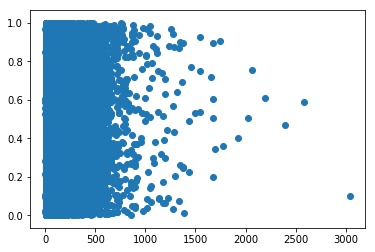

In [321]:
plt.scatter(x=segment_dropped['Monetary'],y=segment_dropped['factor_4']);

Гипотеза о том, что эти четыре фактора ведут себя очень похоже, почти одинаково, подтвердилась. Исходя из этого можно сказать, что если они не просто создают шум, а дают какую-то информацию, то можно использовать один из них

Попробуем посмотреть, сколько главных компонент нужно, чтобы объяснить 100 процентов дисперсии

In [322]:
pca = PCA(n_components=0.99)
pca_result = pca.fit_transform(segment_dropped[['Monetary' ,'Frequency'
                                       ,'factor_1','factor_2' ,'factor_3' , 'factor_4','mean']].values)

In [323]:
pca_result.shape

(16000, 2)

In [324]:
segment_dropped['pca-one'] = pca_result[:,0]
segment_dropped['pca-two'] = pca_result[:,1] 

In [325]:
segment_dropped.describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,mean,pca-one,pca-two
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,1.600000e+04,1.600000e+04
mean,129.972264,3.950687,0.500008,0.497864,0.495451,0.498427,36.570692,-2.173195e-14,-4.996448e-15
std,179.809263,5.189864,0.290144,0.291103,0.289034,0.288478,53.285177,1.815575e+02,4.717628e+01
min,0.000000,1.000000,0.000000,0.000000,0.000037,0.000033,0.000000,-1.338778e+02,-3.354931e+02
25%,20.910000,1.000000,0.250000,0.240000,0.242545,0.248739,13.415000,-1.111116e+02,-1.397763e+01
50%,59.275000,2.000000,0.500000,0.500000,0.496410,0.498833,21.250000,-7.160975e+01,-7.137319e+00
75%,170.000000,5.000000,0.750000,0.750000,0.744476,0.747424,42.500000,3.793304e+01,3.340762e+00
max,3040.000000,111.000000,1.000000,1.000000,0.999996,0.999943,504.000000,2.891277e+03,4.097225e+02


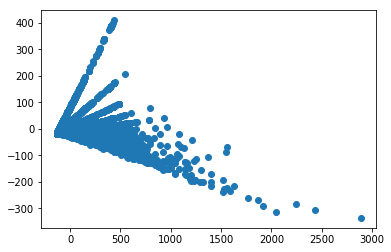

In [326]:
plt.scatter(x=pca_result[:,0],y=pca_result[:,1]);

Всего две компоненты нужно чтобы объяснить 99% дисперсии, однако, проектиция на них не дает какой-либо интерпретируемой информации

Попробуем воспользоваться стандартными методами кластеризации для главных компонент, так как они распределены достаточно близко друг к другу, то масштабирование делать необязательно 

In [327]:
from sklearn.cluster import KMeans

In [328]:
kmeans = KMeans(n_clusters = 3, n_init=100)
kmeans.fit(pca_result)
cluster_labels = kmeans.labels_

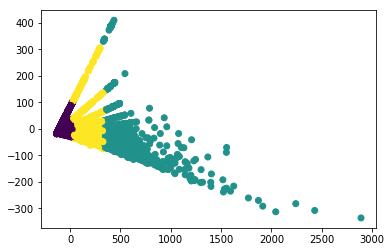

In [329]:
plt.scatter(x=pca_result[:,0],y=pca_result[:,1], c=cluster_labels);

Разбиение на кластеры довольно неопределенное, четкую границу между кластерами не видно.
Попробуем провести кластеризацию по основным признакам

In [330]:
main_features = segment_dropped[['Monetary','Frequency','factor_1','mean']]

In [331]:
kmeans = KMeans(n_clusters = 2, n_init=100)
kmeans.fit(main_features)
cluster_labels = kmeans.labels_

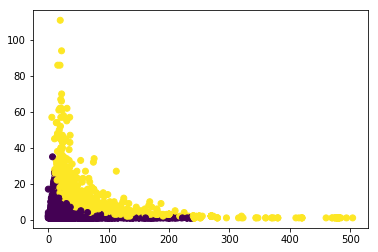

In [332]:
plt.scatter(x=segment_dropped['mean'],y=segment_dropped['Frequency'], c=cluster_labels);

In [333]:
from sklearn.cluster import DBSCAN

In [334]:
db = DBSCAN(min_samples=300,eps=5).fit(main_features)
labels = db.labels_

In [335]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

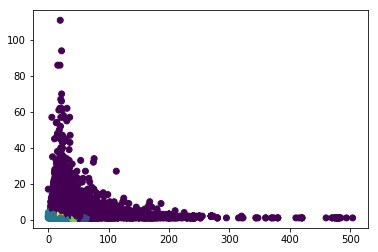

In [336]:
plt.scatter(x=segment_dropped['mean'],y=segment_dropped['Frequency'], c=labels);

DBSACAN так же показал неоднозначные результаты, варьирование параметрами тоже не помогло

Попробуем поработать с датами

In [337]:
#from datetime import date
#def diff_dates(date1, date2):
#   return (date2-date1).days

In [338]:
#dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates]

In [339]:
max_date = segment['Recency'].max()

In [340]:
segment['days_ago'] = (max_date - segment.Recency).dt.days

In [341]:
segment['mean'] = segment['Monetary']/segment['Frequency']

In [342]:
segment = segment.drop(columns=['CustomerId','Recency','factor_1','factor_2','factor_3','factor_4'])

In [343]:
segment.describe()

,Monetary,Frequency,days_ago,mean
count,16000.000000,16000.000000,16000.000000,16000.000000
mean,129.972264,3.950687,58.882688,36.570692
std,179.809263,5.189864,51.236764,53.285177
min,0.000000,1.000000,0.000000,0.000000
25%,20.910000,1.000000,8.000000,13.415000
50%,59.275000,2.000000,50.000000,21.250000
75%,170.000000,5.000000,93.000000,42.500000
max,3040.000000,111.000000,166.000000,504.000000


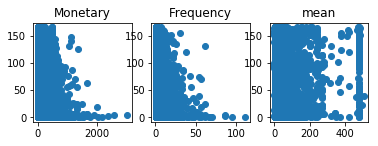

In [344]:
plt.subplot(2,3,1)
plt.scatter(x=segment['Monetary'],y=segment['days_ago']);
plt.title('Monetary')

plt.subplot(2,3,2)
plt.scatter(x=segment['Frequency'],y=segment['days_ago']);
plt.title('Frequency')

plt.subplot(2,3,3)
plt.scatter(x=segment['mean'],y=segment['days_ago']);
plt.title('mean')

plt.show()

Monetary и Frequency приблизительно одинаково ведут себя с переменной days ago показывают, что люди, которые платят часто или много (причем это могут быть одни и те же люди) совершили свой послежний платеж достаточно недавно. 

По переменной mean сложно что-то сказать однозначное

Исходя из всего проведенного анализа можно предположительно поделить пользователей на категории: 

Первая группа – "высокоэффективные" пользователи те, которые приносят большой доход компании и(или) платят часто, и у которых последний платеж был совсем недавно, то есть до 30 дней. Таких пользователей можно поощрать различными скидками и подарками, тем самым повышая лояльность по отношению к компании.

Вторая группа – "вяленькие" пользователи, которые платят реже или маленькими суммами, и последний платеж у которых был совершен достаточно давно, от одного до трех месяцев. Эту группу пользователей нужно стимулировать на продолжение сотрудничества различными предложениями.

Третья группа – скорее всего ушедшие пользователи, они немного платили и совершали редкие платежи, причем более трех месяцев назад, исходя из этого можно сделать предположение, что они по большей части уже не заинтересованы в продукте, хотя, возможно, сильные изменения их могут привлеч.

Также можно попытаться выделить группы Other, куда бы попали пользователи, отклоняющиеся на графиках от основного скопления точек. Это пользователи, которые совершали свои платежи достаточно давно, но часто или по-многу. 

In [345]:
segment1 = segment.copy()

In [346]:
segment1['class'] = 0

In [353]:
segment1.head()

,Monetary,Frequency,days_ago,mean,class
0,100.40,6,12,16.733333,0
1,170.00,4,22,42.500000,0
2,70.75,6,22,11.791667,0
3,75.00,10,88,7.500000,0
4,94.51,5,67,18.902000,0


In [348]:
#segment1[segment1['days_ago'] > 100].count()

In [349]:
#segment1[segment1['days_ago'] < 31].count()

In [372]:
segment1 = segment1.sort_values(by='days_ago')

In [373]:
segment1['class'].iloc[3212:] = int(3)
segment1['class'].iloc[0:6624] = int(1)
segment1['class'].iloc[6623:12788] = int(2)
#segment1['class'].iloc[0:6624] = int(1)

C:\Users\LENOVO\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [364]:
np.unique(segment1['class'])

array([1, 2, 3], dtype=int64)

Описание получившихся классов

In [374]:
#Класс 1
segment1[segment1['class']==1].describe()

,Monetary,Frequency,days_ago,mean,class
count,6623.000000,6623.000000,6623.000000,6623.000000,6623.0
mean,183.073219,5.259852,9.320701,39.419337,1.0
std,218.860634,6.553589,8.292330,47.614336,0.0
min,0.000000,1.000000,0.000000,0.000000,1.0
25%,39.340000,2.000000,2.000000,15.001250,1.0
50%,110.000000,3.000000,7.000000,27.500000,1.0
75%,260.000000,6.000000,15.000000,48.000000,1.0
max,3040.000000,111.000000,30.000000,493.790000,1.0


In [375]:
#Класс 2
segment1[segment1['class']==2].describe()

,Monetary,Frequency,days_ago,mean,class
count,6165.000000,6165.000000,6165.000000,6165.000000,6165.0
mean,106.548174,3.532522,70.392539,33.029899,2.0
std,143.424911,4.082908,20.561418,46.647830,0.0
min,0.000000,1.000000,31.000000,0.000000,2.0
25%,20.800000,1.000000,54.000000,12.370000,2.0
50%,50.140000,2.000000,73.000000,20.158571,2.0
75%,130.000000,4.000000,88.000000,39.680000,2.0
max,1660.000000,57.000000,100.000000,504.000000,2.0


In [376]:
#№ласс 3
segment1[segment1['class']==3].describe()

,Monetary,Frequency,days_ago,mean,class
count,3212.000000,3212.000000,3212.000000,3212.000000,3212.0
mean,65.439851,2.053861,138.985679,37.492988,3.0
std,108.562651,2.481679,19.684536,72.475610,0.0
min,0.000000,1.000000,101.000000,0.000000,3.0
25%,13.420000,1.000000,121.000000,9.157500,3.0
50%,25.010000,1.000000,141.000000,16.705000,3.0
75%,60.280000,2.000000,158.000000,35.252500,3.0
max,1364.000000,61.000000,166.000000,484.390000,3.0


Из описательной статистики явно видно, как разнятся значения средней принесенной прибыли и среднего количества транзакций. В целом, это достаточно хорошо описывает картину потребления продукта.
* У первого класса Monetary = 183, Frequency = 5.25
* У второго класса Monetary = 106, Frequency = 3.5
* У третьего класса Monetary = 65, Frequency = 2

Отобразим получившиеся кластеры

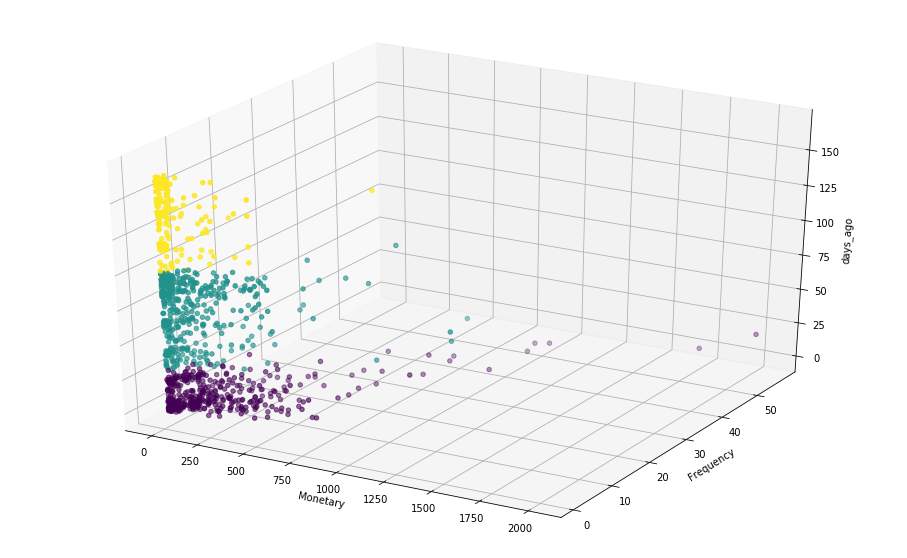

In [377]:
rndperm = list(range(1,1000))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=segment1.loc[rndperm,:]["Monetary"], 
    ys=segment1.loc[rndperm,:]["Frequency"], 
    zs=segment1.loc[rndperm,:]["days_ago"],
    c=segment1.loc[rndperm,:]['class']
)
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('days_ago')
plt.show()

На приведенном выше графике отчетливо видно, как в каждом классе есть ряд точек, которые сильно отбиваются от общего скопления, именно эти точки можно было отнести в кластер Other